In [41]:
import numpy as np
import matplotlib.pyplot as plt

In [42]:
N_CITIES = 20  # DNA size
CROSS_RATE = 0.1
MUTATE_RATE = 0.02
POP_SIZE = 500
N_GENERATIONS = 500

In [43]:
%mkdir utils

mkdir: utils: File exists


In [44]:
%%writefile ./utils/genetic_algorithm.py

import numpy as np
import matplotlib.pyplot as plt

class GA(object):
    def __init__(self, DNA_size, cross_rate, mutation_rate, pop_size, ):
        self.DNA_size = DNA_size
        self.cross_rate = cross_rate
        self.mutate_rate = mutation_rate
        self.pop_size = pop_size
        np.random.shuffle(arr := np.stack([np.random.permutation(DNA_size) for _ in range(pop_size)]))
        self.pop = arr
        
    def translateDNA(self, DNA, city_position):     # get cities' coord in order
        line_x = np.empty_like(DNA, dtype=np.float64)
        line_y = np.empty_like(DNA, dtype=np.float64)
        for i, d in enumerate(DNA):
            city_coord = city_position[d]
            line_x[i, :] = city_coord[:, 0]
            line_y[i, :] = city_coord[:, 1]
        return line_x, line_y

    def get_fitness(self, line_x, line_y):
        total_distance = np.empty((line_x.shape[0],), dtype=np.float64)
        for i, (xs, ys) in enumerate(zip(line_x, line_y)):
            total_distance[i] = np.sum(np.sqrt(np.square(np.diff(xs)) + np.square(np.diff(ys))))
        fitness = np.exp(self.DNA_size * 2 / total_distance)
        return fitness, total_distance

    def select(self, fitness):
        idx = np.random.choice(np.arange(self.pop_size), size=self.pop_size, replace=True, p=fitness / fitness.sum())
        return self.pop[idx]

    def crossover(self, parent, pop):
        if np.random.rand() < self.cross_rate:
            i_ = np.random.randint(0, self.pop_size, size=1)                        # select another individual from population
            cross_points = np.random.randint(0, 2, self.DNA_size).astype(np.bool)   # choose crossover points
            keep_city = parent[~cross_points]                                       # find the city number
            swap_city = pop[i_, np.isin(pop[i_].ravel(), keep_city, invert=True)]
            parent[:] = np.concatenate((keep_city, swap_city))
        return parent

    def mutate(self, child):
        for point in range(self.DNA_size):
            if np.random.rand() < self.mutate_rate:
                swap_point = np.random.randint(0, self.DNA_size)
                swapA, swapB = child[point], child[swap_point]
                child[point], child[swap_point] = swapB, swapA
        return child

    def evolve(self, fitness):
        pop = self.select(fitness)
        pop_copy = pop.copy()
        for parent in pop:  # for every parent
            child = self.crossover(parent, pop_copy)
            child = self.mutate(child)
            parent[:] = child
        self.pop = pop


class TravelSalesPerson(object):
    def __init__(self, n_cities):
        self.city_position = np.random.rand(n_cities, 2)
        plt.ion()

    def plotting(self, lx, ly, total_d):
        plt.cla()
        plt.scatter(self.city_position[:, 0].T, self.city_position[:, 1].T, s=100, c='k')
        plt.plot(lx.T, ly.T, 'r-')
        plt.text(-0.05, -0.05, "Total distance=%.2f" % total_d, fontdict={'size': 20, 'color': 'red'})
        plt.xlim((-0.1, 1.1))
        plt.ylim((-0.1, 1.1))
        plt.pause(0.01)

Overwriting ./utils/genetic_algorithm.py


In [45]:
from utils.genetic_algorithm import *
ga = GA(DNA_size=N_CITIES, cross_rate=CROSS_RATE, mutation_rate=MUTATE_RATE, pop_size=POP_SIZE)

env = TravelSalesPerson(N_CITIES)

Gen: 499 | best fit: 70212.45


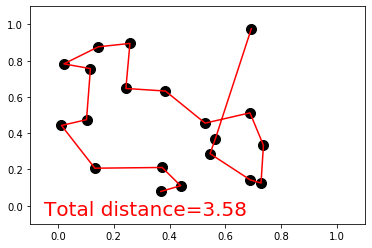

In [46]:
from IPython.display import display, clear_output
import time
for generation in range(N_GENERATIONS):
    lx, ly = ga.translateDNA(ga.pop, env.city_position)
    fitness, total_distance = ga.get_fitness(lx, ly)
    ga.evolve(fitness)
    best_idx = np.argmax(fitness)
    print('Gen:', generation, '| best fit: %.2f' % fitness[best_idx],)

#     env.plotting(lx[best_idx], ly[best_idx], total_distance[best_idx])
    clear_output(wait=True)
#     time.sleep(0.01)

print('Gen:', generation, '| best fit: %.2f' % fitness[best_idx],)
env.plotting(lx[best_idx], ly[best_idx], total_distance[best_idx])